# binder/tag MCMC
### Edited from MCMC_BT_ExperimentalData.ipynb to run validation using a ground-truth dataset
Author(s): Cody Herron, Mike pablo


In [2]:
import sys
sys.executable

'/Users/macowner/opt/anaconda3/envs/matlabEnv/bin/python'

In [3]:
# eng.quit()

In [4]:
# import required packages
import numpy as np
import scipy.io as sio
import pandas as pd
from scipy.integrate import odeint
from scipy import stats
from pymcmcstat import MCMC
from pymcmcstat import MCMC, structures, plotting, propagation
from pymcmcstat.plotting import MCMCPlotting
from pymcmcstat.chain import ChainStatistics
import matlab.engine 
import matplotlib.pyplot as plt
import seaborn as sns
np.seterr(over='ignore');

import matplotlib
matplotlib.rcParams['pdf.fonttype']=42
matplotlib.rcParams['ps.fonttype']=42
matplotlib.rcParams['font.sans-serif']="Arial"
matplotlib.rcParams['font.family']="sans-serif"

The data is saved in a `.mat` file as the original example comes from the Matlab.  We extract the necessary data as follows

In [2]:
bt_data = sio.loadmat('LL_MCMC_Val/BT_all_sim_data.mat',struct_as_record=True)

bt_data_2 = sio.loadmat('../simSF_FixedK3_CorrectN.mat',struct_as_record=True)


# bt_exp_data = sio.loadmat('LL_MCMC/BT_all_exp_data.mat',struct_as_record=True) 

# Define Mean Square Error and Model Functions

In [6]:
eng = matlab.engine.start_matlab() 

def BT_mse(params,mc_data):
    
    def mse(A,B):
        A = A[~np.isnan(A)]
        B = B[~np.isnan(B)]
        return(np.mean(np.subtract(A,B)**2))

    ndp, nbatch = mc_data.shape[0]
    exp_lft = np.array(mc_data.ydata).T[:3] #np.array(mc_data.ydata[0])
    exp_cat = np.array(mc_data.ydata).T[3] #np.array(mc_data.ydata[1]).flatten()
    exp_proc = np.array(mc_data.ydata).T[4:] #np.array(mc_data.ydata[2])

    sim_dists = run_BT(params)
    if np.shape(sim_dists) != (75,8) :
        return(np.ones(8)*np.inf)
    
    sim_lft = np.array(sim_dists.T[:3])
    sim_cat =  np.array(sim_dists.T[3])
    sim_proc =  np.array(sim_dists.T[4:])

    mse_lft = [mse(exp_lft[i],sim_lft[i]) for i in range(3)]
    mse_cat = [mse(exp_cat,sim_cat)]
    mse_proc = [mse(exp_proc[i],sim_proc[i]) for i in range(4)]
    return(np.hstack([mse_lft,mse_cat,mse_proc]))

# def run_BT(params):
#     params = [float(p) for p in params]
#     out = eng.markov_distributions(*params)
#     return([np.asarray(out[i]).flatten() for i in range(len(out))])

def run_BT(params, data=None):
    params = [float(p) for p in params]
    out = eng.markov_distributions(*params)
    out = [np.asarray(out[i]) for i in range(len(out))]
    
    if len(out)==0:
        return(out)
        
    pad = len(max(out, key=len))
    out = np.array([np.concatenate([d.flatten(), np.full(pad-len(d), np.nan)]) for d in out])
    
    return(np.array(out).T)

# Initialize MCMC Object and Setup Simulation
- Define data structure
- Assign parameters and define constraints
- Set simulation options and model settings

In [8]:
# initialize MCMC object
mcstat = MCMC.MCMC()


mcstat.data.add_data_set(x=np.arange(0,75),
                         y=exp_data,
                         user_defined_object=exp_x)

# initialize parameter array
#theta = [5.31,  8.88,  1.39,  2.98,  0.63, 12.1 ,  0.23,  0.15]
# add model parameters
mcstat.parameters.add_model_parameter(name='k1', theta0=5.31, minimum=0)
mcstat.parameters.add_model_parameter(name='k2', theta0=8.88, minimum=0)
mcstat.parameters.add_model_parameter(name='k3', theta0=1.39, minimum=0)
mcstat.parameters.add_model_parameter(name='k4', theta0=2.98, minimum=0)
mcstat.parameters.add_model_parameter(name='k6', theta0=0.63, minimum=0)
mcstat.parameters.add_model_parameter(name='k7', theta0=12.1, minimum=0)
mcstat.parameters.add_model_parameter(name='k8', theta0=0.23, minimum=0)
mcstat.parameters.add_model_parameter(name='f1', theta0=0.15, minimum=0,maximum=0.76)


# Generate options
mcstat.simulation_options.define_simulation_options(
    nsimu=1.0e1, updatesigma=True, 
    verbosity=False,save_to_json=True,
    save_lightly=False, waitbar=False )
     #save_to_json=True, verbosity=0, waitbar=True, save_to_bin=True)
# Define model object:
mcstat.model_settings.define_model_settings(
    sos_function=BT_mse,
    nbatch = 8,
    sigma2=0.01**2,S20=0.01*np.ones(8),N0=0.5*np.ones(8))

The code takes some time to run, so here we simply check to make sure the data structure can be processed using our sum-of-squares function.  Note, we have separate sum-of-squares for each quantity of interest and there will be a separate error variance for each as well.

In [13]:
# check model evaluation
params = np.array([5.31,  8.88,  1.39,  2.98,  0.63, 12.1 ,  0.23,  0.15],dtype=np.float)
mse = BT_mse(params,mcstat.data)
print('EA Best Param Set MSE: ', mse)
print('EA Best Param Set Sum MSE: ', sum(mse))

EA Best Param Set MSE:  [1.45362461e-04 4.30513724e-05 1.13414579e-04 2.87643213e-04
 4.13899622e-05 1.10024544e-05 3.40505420e-05 1.35425504e-04]
EA Best Param Set Sum MSE:  0.0008113400878336011


# Run simulation
- We run an initialize sequence of 1000, then restart and perform another 5000

In [136]:
# Run simulation
mcstat.run_simulation()
# # Rerun starting from results of previous run
mcstat.simulation_options.nsimu = int(50)
mcstat.run_simulation(use_previous_results=True)

# Extract results and plot chain diagnostics
- chain panel
- density panel
- pairwise correlation panel

In [15]:
# # extract info from results
# results = mcstat.simulation_results.results
# chain = results['chain']
# s2chain = results['s2chain']
# names = results['names'] # parameter names

# # display chain stats
# # mcstat.chainstats(chain, results)

# mcpl = MCMCPlotting
# # plot chain panel
# mcpl.plot_chain_panel(chain, names, figsizeinches=[7, 6])
# # plot density panel
# mcpl.plot_density_panel(chain, names, figsizeinches=[7, 6])
# # pairwise correlation
# mcpl.plot_pairwise_correlation_panel(chain, names, figsizeinches=[7, 6])

# Generate prediction/credible intervals for each quantity of interest
## Generate intervals

In [139]:
# intervals = propagation.calculate_intervals(results['chain'][10:], results, mcstat.data, run_BT,
#                                                 waitbar=True, nsample=20,s2chain = s2chain[10:])

 [-----------------105%------------------] 21 of 20 complete in 63.6 sec

In [140]:
# def get_MCMC_plot_settings():
#     data_display = dict(marker='o',
#                         color='k',
#                         mfc='none',
#                         label='Data')
#     model_display = dict(color='r')
#     interval_display = dict(alpha=0.5)

#     return data_display, model_display, interval_display

# data_display, model_display, interval_display = get_MCMC_plot_settings()

In [16]:
# for ii, interval in enumerate(intervals):
#         fig, ax = propagation.plot_intervals(interval,
#                                              time=np.array(mcstat.data.user_defined_object).T[ii].T,
#                                              ydata=mcstat.data.ydata[0][:, ii],
#                                              data_display=data_display,
#                                              model_display=model_display,
#                                              interval_display=interval_display,
#                                              legloc='upper right')

# Validation chains (after simulation on Longleaf computing cluster)

In [5]:
outputfile1 = 'Validation_MCMC_SimulationChains/MCMCRun20210323239229_035/MCMCRun20210323.json'
outputfile1 = [outputfile1]

# this run was continued, need to merge chains
outputfile2_orig =  'Validation_MCMC_SimulationChains/MCMCRun2021031435042/MCMCRun20210314.json'
outputfile2_cont =  'Validation_MCMC_SimulationChains/MCMCRun2021031435042/20210317_175807_mcmc_simulation.json'
outputfile2 = [outputfile2_orig,outputfile2_cont]

outputfile3 = 'Validation_MCMC_SimulationChains/MCMCRun20210323210819_035/MCMCRun20210323.json'
outputfile3 = [outputfile3]



chains = []
burn_in_chains = []
for o in [outputfile1,outputfile2,outputfile3]: #,outputfile4,outputfile5]: #all_jsons:
    

    results_orig = structures.ResultsStructure.ResultsStructure.load_json_object(o[0])
    for ii, key in enumerate(results_orig):
        results_orig[key] = np.array(results_orig[key])
        
    try:
        results_cont = structures.ResultsStructure.ResultsStructure.load_json_object(o[1])
            
        for ii, key in enumerate(results_cont):
            results_cont[key] = np.array(results_cont[key])
        
        chain = np.vstack([results_orig['chain'], results_cont['chain']])
        s2chain = np.vstack([results_orig['s2chain'], results_cont['s2chain']])
    except:
        chain = results_orig['chain']
        s2chain = results_orig['s2chain']



#     chain = results['chain']
    chains.append(chain)
#     print(results['chain'][-1])
    names = results_orig['names']
#     s2chain = results['s2chain']
    print(ChainStatistics.chainstats(chain))

    
    curr_chain = chain[-5000:]
    print(ChainStatistics.chainstats(curr_chain))
    burn_in_chains.append(curr_chain)




------------------------------
      name:      mean       std    MC_err       tau    geweke
   $p_{0}$:      5.65      5.97      1.16   1387.97      0.02
   $p_{1}$:      7.69      4.12      0.70   1199.69      0.16
   $p_{2}$:      1.43      0.83      0.13    433.57      0.09
   $p_{3}$:      1.84      0.81      0.12    402.76      0.36
   $p_{4}$:     10.68      3.18      0.47    442.05      0.48
   $p_{5}$:      0.24      0.04  5.69e-03    338.99      0.67
   $p_{6}$:      0.15      0.14      0.03   1356.17      0.03
------------------------------
Acceptance rate information
Chain provided:
Net    : 24.77% -> 2725/10999
------------------------------
None


------------------------------
      name:      mean       std    MC_err       tau    geweke
   $p_{0}$:     10.78      5.14      0.86    149.21      0.50
   $p_{1}$:     10.43      3.77      0.53     85.61      0.72
   $p_{2}$:      1.78      0.80      0.13    166.16      0.25
   $p_{3}$:      1.54      0.76      0.12    165.

### Visualize validation chains

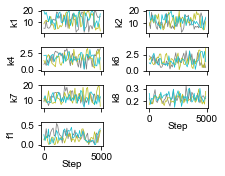

In [337]:
from matplotlib.lines import Line2D

colors = sns.color_palette('tab10')
burn_in_chains = np.array(burn_in_chains)

plt.figure(figsize=(3.,2.5))

for i in range(np.shape(burn_in_chains)[2]):

    plt.subplot(4,2,i+1)
    plt.ylabel(names[i])

    for j in range(np.shape(burn_in_chains)[0]):
        x,y = range(len(burn_in_chains[j,:,i])),burn_in_chains[j,:,i].flatten()
        plt.plot(x[::100],y[::100],lw=0.75,color=colors[j+7])
#     plt.tight_layout()
    ax = plt.gca()
    if i < 5:
        ax.set_xticklabels([])
    else:
        plt.xlabel('Step',labelpad=-2)
    
        


custom_lines = [Line2D([0], [0], color=colors[7], lw=4),
            Line2D([0], [0], color=colors[8], lw=4),
            Line2D([0], [0], color=colors[9], lw=4)]

# plt.subplot(3,3,8)
# plt.axis('off')
# plt.legend(custom_lines, ['Val. Chain 1','Val. Chain 2','Val. Chain 3'])
plt.subplots_adjust(wspace=0.7, hspace=0.6)
        
# plt.savefig('MCMC_Chains_Validation.pdf',dpi=300,bbox_inches = "tight",transparent=True)

### Chain stats

In [39]:
for i in range(3): print(ChainStatistics.chainstats(chain=burn_in_chains[i]))



------------------------------
      name:      mean       std    MC_err       tau    geweke
   $p_{0}$:     10.78      5.14      0.86    149.21      0.50
   $p_{1}$:     10.43      3.77      0.53     85.61      0.72
   $p_{2}$:      1.78      0.80      0.13    166.16      0.25
   $p_{3}$:      1.54      0.76      0.12    165.14      0.54
   $p_{4}$:     12.00      3.16      0.47    200.00      0.56
   $p_{5}$:      0.22      0.03  3.77e-03     51.57      0.90
   $p_{6}$:      0.24      0.13      0.02    272.87      0.59
------------------------------
Acceptance rate information
Chain provided:
Net    : 23.16% -> 1158/5000
------------------------------
None


------------------------------
      name:      mean       std    MC_err       tau    geweke
   $p_{0}$:     11.25      4.95      0.78    225.94      0.85
   $p_{1}$:     11.76      4.13      0.63    165.36      0.86
   $p_{2}$:      1.78      0.75      0.10     81.92      0.80
   $p_{3}$:      1.52      0.76      0.10     76.9

In [40]:
gr = ChainStatistics.gelman_rubin(burn_in_chains)

print('Gelman-Rubin Diagnostic: ')
for key in gr.keys():
    print(gr[key]['R'])

Parameter: $p_{0}$
  R = 1.0517890717883553
  B = 9931.88296002143
  W = 24.87784956849562
  V = 27.521376121254303
  neff = 41.56519397988595
Parameter: $p_{1}$
  R = 1.0601066735202103
  B = 6992.396889690044
  W = 15.034241018013278
  V = 16.89587334039369
  neff = 36.244810485455666
Parameter: $p_{2}$
  R = 1.002339866158575
  B = 10.205542300714644
  W = 0.5570854591959921
  V = 0.5596955200510102
  neff = 822.6346580501912
Parameter: $p_{3}$
  R = 1.0080184771290235
  B = 34.65577163567144
  W = 0.566922105388265
  V = 0.5760502600700331
  neff = 249.33087601940755
Parameter: $p_{4}$
  R = 1.0273724827795339
  B = 2139.40348201418
  W = 10.243569474073514
  V = 10.812028355382482
  neff = 75.80637626056846
Parameter: $p_{5}$
  R = 1.0574447989288642
  B = 0.473623342706737
  W = 0.0010668138229113827
  V = 0.0011929000182019302
  neff = 37.78002192790661
Parameter: $p_{6}$
  R = 1.1024120606720518
  B = 10.859368110516554
  W = 0.013436963012922786
  V = 0.01633010711645795
  nef

### More chain visualization of full chains versus post-burn-in chains

/Users/macowner/opt/anaconda3/envs/matlabEnv/lib/python3.6/site-packages/ipykernel_launcher.py:79: DeprecationWarning: Call to deprecated function (or staticmethod) plot_chain_panel. (New function:"from pymcmcstat.mcmcplot import plot_chain_panel") -- Deprecated since version 1.9.0.




------------------------------
      name:      mean       std    MC_err       tau    geweke
   $p_{0}$:     10.78      5.14      0.86    149.21      0.50
   $p_{1}$:     10.43      3.77      0.53     85.61      0.72
   $p_{2}$:      1.78      0.80      0.13    166.16      0.25
   $p_{3}$:      1.54      0.76      0.12    165.14      0.54
   $p_{4}$:     12.00      3.16      0.47    200.00      0.56
   $p_{5}$:      0.22      0.03  3.77e-03     51.57      0.90
   $p_{6}$:      0.24      0.13      0.02    272.87      0.59
------------------------------
Acceptance rate information
Chain provided:
Net    : 23.16% -> 1158/5000
------------------------------
None


/Users/macowner/opt/anaconda3/envs/matlabEnv/lib/python3.6/site-packages/ipykernel_launcher.py:79: DeprecationWarning: Call to deprecated function (or staticmethod) plot_chain_panel. (New function:"from pymcmcstat.mcmcplot import plot_chain_panel") -- Deprecated since version 1.9.0.




------------------------------
      name:      mean       std    MC_err       tau    geweke
   $p_{0}$:     11.25      4.95      0.78    225.94      0.85
   $p_{1}$:     11.76      4.13      0.63    165.36      0.86
   $p_{2}$:      1.78      0.75      0.10     81.92      0.80
   $p_{3}$:      1.52      0.76      0.10     76.91      0.98
   $p_{4}$:     11.87      3.61      0.53    135.27      0.99
   $p_{5}$:      0.21      0.03  4.10e-03    102.19      0.94
   $p_{6}$:      0.15      0.09      0.01    155.46      0.51
------------------------------
Acceptance rate information
Chain provided:
Net    : 24.78% -> 1239/5000
------------------------------
None


/Users/macowner/opt/anaconda3/envs/matlabEnv/lib/python3.6/site-packages/ipykernel_launcher.py:79: DeprecationWarning: Call to deprecated function (or staticmethod) plot_chain_panel. (New function:"from pymcmcstat.mcmcplot import plot_chain_panel") -- Deprecated since version 1.9.0.




------------------------------
      name:      mean       std    MC_err       tau    geweke
   $p_{0}$:     13.42      4.87      0.74     92.00      0.86
   $p_{1}$:     12.79      3.72      0.52    183.44      0.82
   $p_{2}$:      1.70      0.68      0.09    103.78      0.88
   $p_{3}$:      1.67      0.74      0.11    185.97      0.97
   $p_{4}$:     10.81      2.77      0.34     72.74      0.98
   $p_{5}$:      0.23      0.03  3.51e-03     65.63      0.87
   $p_{6}$:      0.23      0.12      0.02    209.36      0.93
------------------------------
Acceptance rate information
Chain provided:
Net    : 18.60% -> 930/5000
------------------------------
None


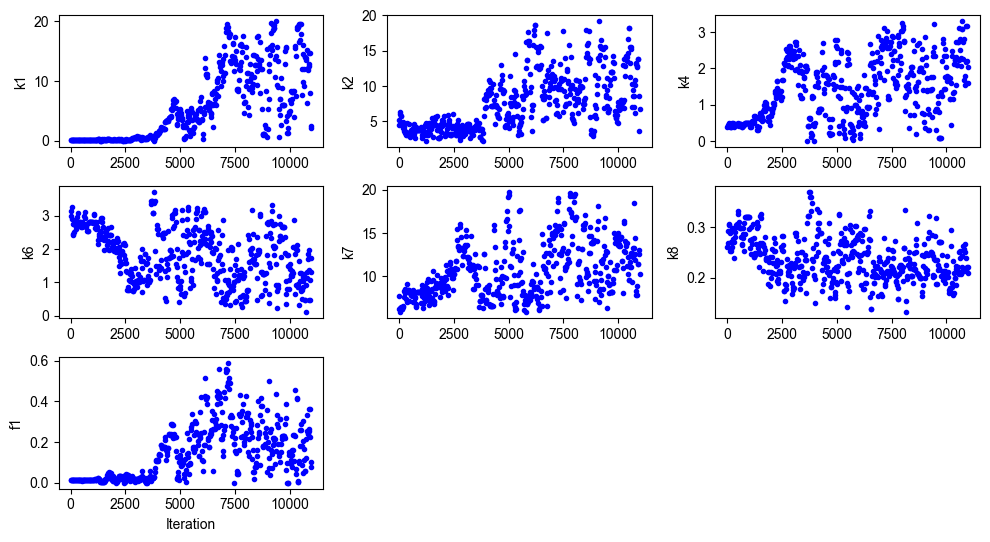

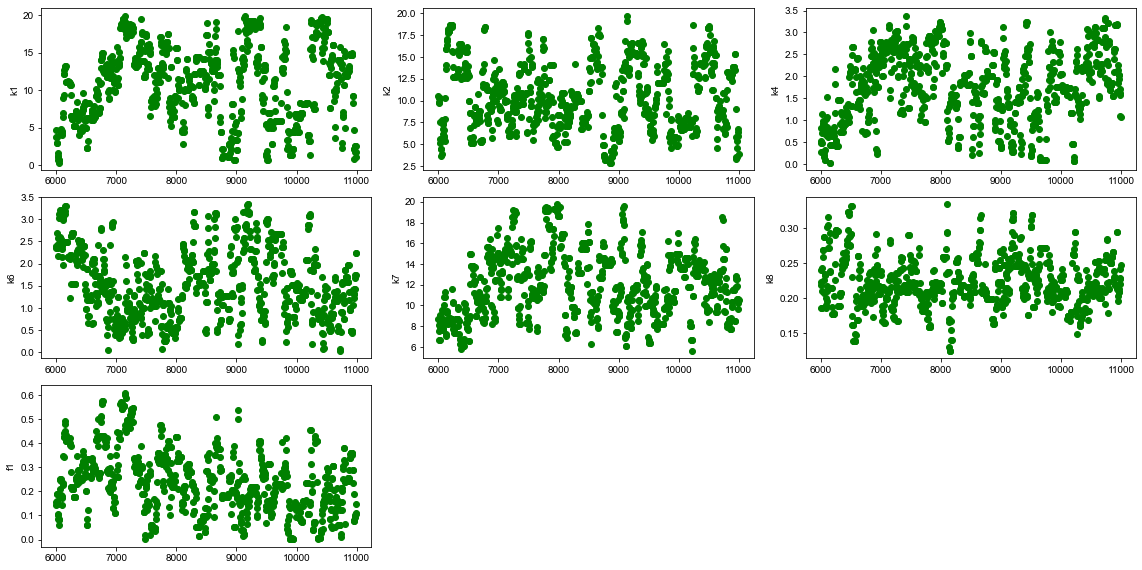

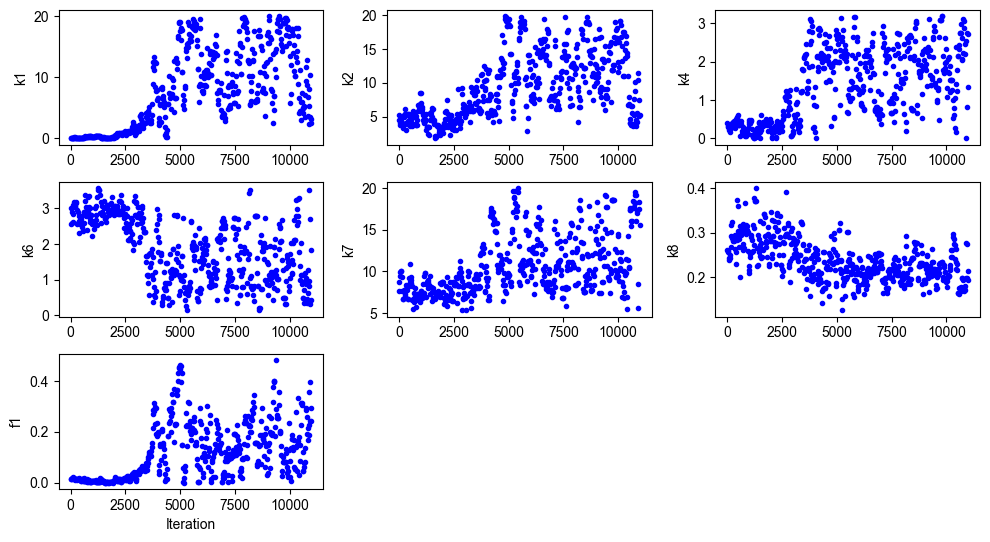

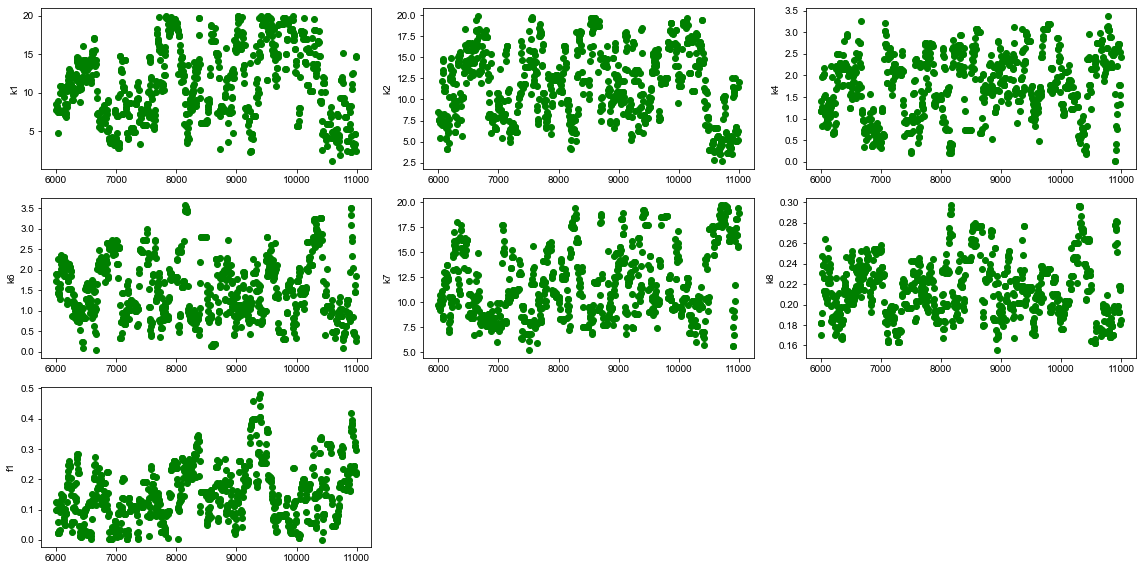

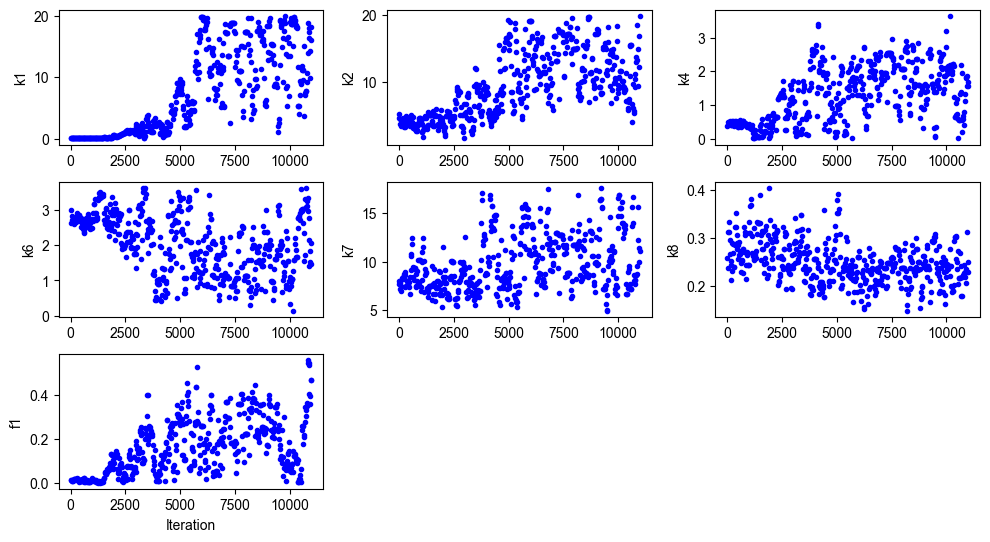

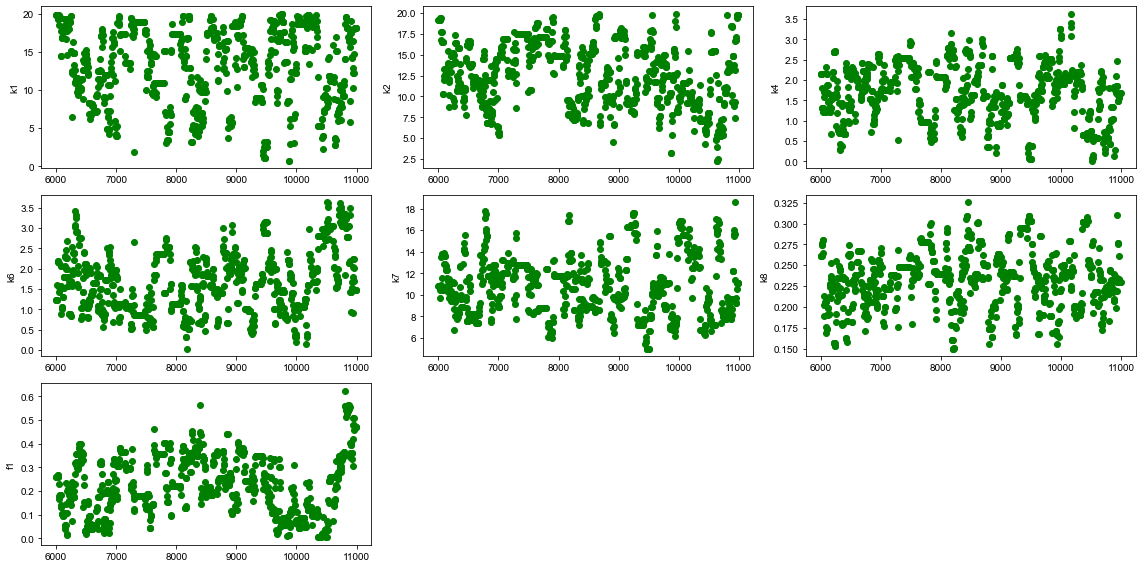

In [315]:
chains = []


outputfile1 = 'Validation_MCMC_SimulationChains/MCMCRun20210323239229_035/MCMCRun20210323.json'
outputfile1 = [outputfile1]
outputfile2_orig =  'Validation_MCMC_SimulationChains/MCMCRun2021031435042/MCMCRun20210314.json'
outputfile2_cont =  'Validation_MCMC_SimulationChains/MCMCRun2021031435042/20210317_175807_mcmc_simulation.json'
outputfile2 = [outputfile2_orig,outputfile2_cont]

outputfile3 = 'Validation_MCMC_SimulationChains/MCMCRun20210323210819_035/MCMCRun20210323.json'
outputfile3 = [outputfile3]


chains = []
burn_in_chains = []
for o in [outputfile1,outputfile2,outputfile3]: #all_jsons:
    

    results_orig = structures.ResultsStructure.ResultsStructure.load_json_object(o[0])
    for ii, key in enumerate(results_orig):
        results_orig[key] = np.array(results_orig[key])
        
    try:
        results_cont = structures.ResultsStructure.ResultsStructure.load_json_object(o[1])
            
        for ii, key in enumerate(results_cont):
            results_cont[key] = np.array(results_cont[key])
        
        chain = np.vstack([results_orig['chain'], results_cont['chain']])
        s2chain = np.vstack([results_orig['s2chain'], results_cont['s2chain']])
    except:
        chain = results_orig['chain']
        s2chain = results_orig['s2chain']



#     chain = results['chain']
    chains.append(chain)
#     print(results['chain'][-1])
    names = results_orig['names']
#     s2chain = results['s2chain']

#     settings = dict(
#         fig=dict(figsize=(7, 6))
#     )
#     # plot chain panel

    mcp = MCMCPlotting
    mcp.plot_chain_panel(chain, names,figsizeinches=(10,6))
#     # plot density panel
#     mcp.plot_density_panel(chain, names,figsizeinches=(10,10))
#     # pairwise correlation
#     f = mcp.plot_pairwise_correlation_panel(chain, names)
#     plt.figure(figsize=(10,8))
#     plt.xlabel('MCMC Steps')
#     plt.ylabel('Sum MSEs')
#     plt.title('Summed MSE (or "SS") Chain')
#     # plt.plot(np.sum(s2chain,axis=1))
#     plt.plot(np.sum(results['sschain'],axis=1))
#     plt.hlines(0.00036,0,len(results['sschain']),'red','--')
#     plt.hlines(0.0008,0,len(results['sschain']),'red','--')
#     # plt.yscale('log')

# #     plt.legend(['MCMC','Original Param Set Range'])
#     print(results['total_rejected'], results['model_settings'])

    
#     geweke = np.zeros(7)

#     curr_chain = chain

#     while np.min(geweke)<0.25:
#         geweke = ChainStatistics.geweke(chain=curr_chain,a=0.1,b=0.9)[1]
#         curr_chain = curr_chain[10:]
        
#     burn_in_chains.append(curr_chain)

#     print(ChainStatistics.chainstats(curr_chain))
    
    curr_chain = chain[-5000:]
    print(ChainStatistics.chainstats(curr_chain))
    burn_in_chains.append(curr_chain)
    plt.figure(figsize=(16,8))
    for i,p_chain in enumerate(curr_chain.T):
        plt.subplot(3,3,i+1)
        plt.ylabel(names[i])
#         x,y = range(len(chain.T[i])),chain.T[i]
#         plt.scatter(x[::10],y[::10])
        x,y = range(len(chain.T[i])-len(p_chain),len(chain.T[i])),p_chain
        plt.scatter(x[::5],y[::5],c='g')
    plt.tight_layout()


### Post-burn-in chain stats

In [26]:
gr = ChainStatistics.gelman_rubin(burn_in_chains)

Parameter: $p_{0}$
  R = 1.0160187177355295
  B = 2879.5057955644565
  W = 23.6310515803241
  V = 24.394193582158554
  neff = 127.0748974688728
Parameter: $p_{1}$
  R = 1.019110057423306
  B = 2198.5520623167804
  W = 15.116046846880218
  V = 15.699304187461985
  neff = 107.11120598334917
Parameter: $p_{2}$
  R = 1.0034392824186338
  B = 15.232483279677771
  W = 0.5728871804895072
  V = 0.5768345985946567
  neff = 568.0307550682495
Parameter: $p_{3}$
  R = 1.0023792713198338
  B = 10.231552830995236
  W = 0.5496176876850877
  V = 0.552236178235816
  neff = 809.607574760623
Parameter: $p_{4}$
  R = 1.0134744726635594
  B = 1183.3062119953836
  W = 11.545644806105718
  V = 11.858884000343267
  neff = 150.32732711272453
Parameter: $p_{5}$
  R = 1.008522160773909
  B = 0.07538127983600859
  W = 0.0011608092677014782
  V = 0.0011806787804708736
  neff = 234.94137729674358
Parameter: $p_{6}$
  R = 1.1596087790094884
  B = 15.002390010111261
  W = 0.011599663952995035
  V = 0.0155979813562341

In [71]:
gr = ChainStatistics.gelman_rubin(burn_in_chains)

print('Gelman-Rubin Diagnostic: ')
for key in gr.keys():
    print(gr[key]['R'])

Gelman-Rubin Diagnostic: 
1.0160187177355295
1.019110057423306
1.0034392824186338
1.0023792713198338
1.0134744726635594
1.008522160773909
1.1596087790094884


In [29]:
for i in range(3): print(ChainStatistics.chainstats(chain=burn_in_chains[i]))



------------------------------
      name:      mean       std    MC_err       tau    geweke
   $p_{0}$:     10.78      5.14      0.86    149.21      0.50
   $p_{1}$:     10.43      3.77      0.53     85.61      0.72
   $p_{2}$:      1.78      0.80      0.13    166.16      0.25
   $p_{3}$:      1.54      0.76      0.12    165.14      0.54
   $p_{4}$:     12.00      3.16      0.47    200.00      0.56
   $p_{5}$:      0.22      0.03  3.77e-03     51.57      0.90
   $p_{6}$:      0.24      0.13      0.02    272.87      0.59
------------------------------
Acceptance rate information
Chain provided:
Net    : 23.16% -> 1158/5000
------------------------------
None


------------------------------
      name:      mean       std    MC_err       tau    geweke
   $p_{0}$:     11.25      4.95      0.78    225.94      0.85
   $p_{1}$:     11.76      4.13      0.63    165.36      0.86
   $p_{2}$:      1.78      0.75      0.10     81.92      0.80
   $p_{3}$:      1.52      0.76      0.10     76.9

## Visualize parameter densities for post-burn-in chains

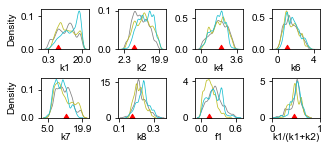

In [321]:
burn_in_chains = np.array(burn_in_chains)

from matplotlib.lines import Line2D

original = [6, 7, 2, 1, 13, 0.17, 0.13]

plt.figure(figsize=(5,2))

for i in range(np.shape(burn_in_chains)[2]):

    plt.subplot(2,4,i+1)

        
    plt.ylabel('Density')
    plt.xlabel(names[i],labelpad=-1)
    all_data = np.vstack(burn_in_chains.T[i])
    for j in range(np.shape(burn_in_chains)[0]):
        sns.kdeplot(x = burn_in_chains[j].T[i],color=colors[j+7],lw=0.75)
    plt.ylabel(None)
    if i == 0 or i == 4:
        plt.ylabel("Density")
    ax = plt.gca()
    ax.set_xticks([np.around(np.min(all_data),1),np.around(np.max(all_data),1)])
    
    if i == 5:
        ax.set_yticks([0,15])
    elif i > 5:
        ax.set_yticks([0,4])
    
    plt.scatter(original[i],0,color='r',marker='d')
#     plt.tight_layout()
        


custom_lines = [Line2D([0], [0], color=colors[7], lw=2),
            Line2D([0], [0], color=colors[8], lw=2),
            Line2D([0], [0], color=colors[9], lw=2)]


original = [6, 7, 2, 1, 13, 0.17, 0.13]

plt.subplot(2,4,8)
ratio = np.hstack(burn_in_chains.T[0]/(burn_in_chains.T[0]+burn_in_chains.T[1]))
# sns.boxplot(x=ratio, ax=ax_box_1,showfliers=False)

# # sns.boxplot(x=np.vstack(chains_burnin[1:].T[1]/burn_in_chains[1:].T[0]), ax=ax_box_2,showfliers=False,color='red')

for j in [0,1,2]:
    sns.kdeplot(x = (burn_in_chains[j].T[0]/(burn_in_chains[j].T[0]+burn_in_chains[j].T[1])),color=colors[j+7],lw=0.75)

plt.xlim([0,1])
plt.xlabel('k1/(k1+k2)',labelpad=-1)
plt.ylabel(None)

plt.scatter(original[0]/(original[0]+original[1]),0,c='r',marker='d')

# plt.legend(custom_lines, ['Val. Chain 1','Val. Chain 2','Val. Chain 3'],bbox_to_anchor=(0, -1.2), loc='lower right', ncol=3)
# plt.tight_layout()
plt.subplots_adjust(wspace=0.6, hspace=0.7)

        
plt.savefig('MCMC_Param_Dens_Validation.pdf',dpi=300,bbox_inches = "tight",transparent=True)

In [48]:
import seaborn as sns

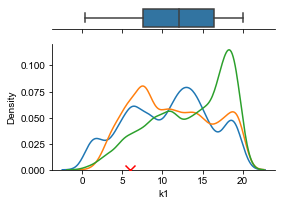

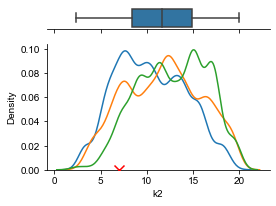

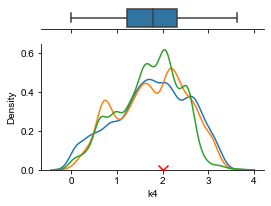

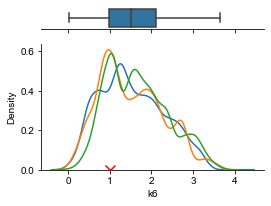

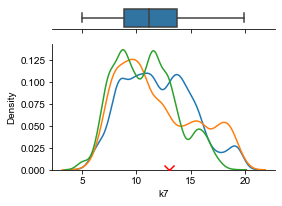

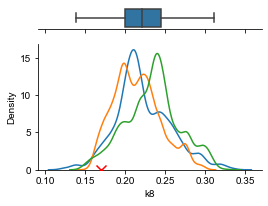

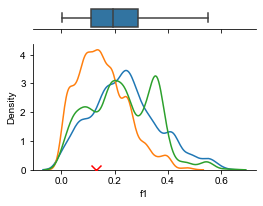

In [49]:
colors = sns.color_palette("tab10")

original = [6, 7, 2, 1, 13, 0.17, 0.13]

for i in range(len(burn_in_chains[0].T)):
    f, (ax_box, ax_hist) = plt.subplots(2,1, sharex=True,gridspec_kw={'height_ratios': [.15,.85]},figsize=(4.,3.))
    
    sns.boxplot(x=np.vstack(burn_in_chains).T[i], ax=ax_box,showfliers=False)
    
    for j in [0,1,2]:
        sns.kdeplot(ax=ax_hist,x = burn_in_chains[j].T[i],color=colors[j])

    ax_hist.set_xlabel(names[i])
    ax_box.set(yticks=[])

    ax_hist.spines['right'].set_visible(False)
    ax_hist.spines['top'].set_visible(False)
    sns.despine(ax=ax_box, left=True)
#     plt.tight_layout()
#     plt.savefig('Figures/KDE_BP_%s.png' %names[i],dpi=300,bbox_inches='tight')
    

    plt.scatter(original[i],0,c='r',marker='x',zorder=10,s=100)

In [52]:
burn_in_chains = np.array(burn_in_chains)

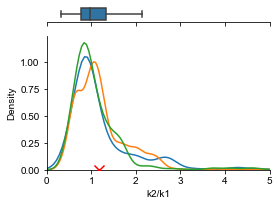

In [70]:
colors = sns.color_palette("tab10")

original = [6, 7, 2, 1, 13, 0.17, 0.13]


    

f, (ax_box_1, ax_hist) = plt.subplots(2,1, sharex=True,gridspec_kw={'height_ratios': [.1,.9]},figsize=(4.,3.))


k2k1_ratio = np.hstack(burn_in_chains.T[1]/burn_in_chains.T[0])
sns.boxplot(x=k2k1_ratio, ax=ax_box_1,showfliers=False)

# sns.boxplot(x=np.vstack(chains_burnin[1:].T[1]/burn_in_chains[1:].T[0]), ax=ax_box_2,showfliers=False,color='red')

for j in [0,1,2]:
    sns.kdeplot(ax=ax_hist,x = burn_in_chains[j].T[1]/burn_in_chains[j].T[0],color=colors[j])

ax_hist.set_xlim([0,5])
ax_hist.set_xlabel('k2/k1')
ax_box_1.set(yticks=[])
ax_box_2.set(yticks=[])

ax_hist.spines['right'].set_visible(False)
ax_hist.spines['top'].set_visible(False)
sns.despine(ax=ax_box_1, left=True)
sns.despine(ax=ax_box_2, left=True)
#     plt.tight_layout()
#     plt.savefig('Figures/KDE_BP_%s.png' %names[i],dpi=300,bbox_inches='tight')


plt.scatter(original[1]/original[0],0,c='r',marker='x',zorder=10,s=100)
plt.show()

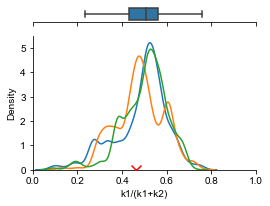

In [67]:
colors = sns.color_palette("tab10")

original = [6, 7, 2, 1, 13, 0.17, 0.13]

f, (ax_box_1, ax_hist) = plt.subplots(2,1, sharex=True,gridspec_kw={'height_ratios': [.1,.9]},figsize=(4.,3.))


ratio = np.hstack(burn_in_chains.T[0]/(burn_in_chains.T[0]+burn_in_chains.T[1]))
sns.boxplot(x=ratio, ax=ax_box_1,showfliers=False)

# sns.boxplot(x=np.vstack(chains_burnin[1:].T[1]/burn_in_chains[1:].T[0]), ax=ax_box_2,showfliers=False,color='red')

for j in [0,1,2]:
    sns.kdeplot(ax=ax_hist,x = (burn_in_chains[j].T[0]/(burn_in_chains[j].T[0]+burn_in_chains[j].T[1])),color=colors[j])

ax_hist.set_xlim([0,1])
ax_hist.set_xlabel('k1/(k1+k2)')
ax_box_1.set(yticks=[])
ax_box_2.set(yticks=[])

ax_hist.spines['right'].set_visible(False)
ax_hist.spines['top'].set_visible(False)
sns.despine(ax=ax_box_1, left=True)
sns.despine(ax=ax_box_2, left=True)
#     plt.tight_layout()
#     plt.savefig('Figures/KDE_BP_%s.png' %names[i],dpi=300,bbox_inches='tight')


plt.scatter(original[0]/(original[0]+original[1]),0,c='r',marker='d',zorder=10,s=100)

In [73]:
print('Original, Ground-Truth Parameters')
print('k1/(k1+k2):',np.around(original[0]/(original[0]+original[1]),3))

print('\nMedian and IQR')
print('k1/(k1+k2):',np.around(np.median(ratio),3),np.around(np.quantile(ratio,[0.25,0.75]),3))
    
# Mean + stdev
print('\nMean and SD')
print('k1/(k1+k2):',np.around(np.mean(ratio),3),u"\u00B1",np.around(np.std(ratio),3))


Original, Ground-Truth Parameters
k1/(k1+k2): 0.462

Median and IQR
k1/(k1+k2): 0.505 [0.43  0.562]

Mean and SD
k1/(k1+k2): 0.489 ± 0.11


In [101]:
chains = np.array(chains)
chains_bi = chains[:,-5000:]
np.shape(chains_bi)

(3, 5000, 7)

In [54]:
# Parameter Quantile Stats

print('Original, Ground-Truth Parameters')
for i,name in enumerate(names):
    print(name,": ",original[i],'s⁻¹')

print('\nMedian and IQR')
for i,row in enumerate(np.vstack(burn_in_chains).T):
    print(names[i],": ",np.around(np.median(row),3),'s⁻¹',np.around(np.quantile(row,[0.25,0.75]),3))
    
# Mean + stdev
print('\nMean and SD')
for i,row in enumerate(np.vstack(burn_in_chains).T):
    print(names[i],": ",np.around(np.mean(row),3),u"\u00B1",np.around(np.std(row),3), 's⁻¹' )


Original, Ground-Truth Parameters
k1 :  6 s⁻¹
k2 :  7 s⁻¹
k4 :  2 s⁻¹
k6 :  1 s⁻¹
k7 :  13 s⁻¹
k8 :  0.17 s⁻¹
f1 :  0.13 s⁻¹

Median and IQR
k1 :  12.014 s⁻¹ [ 7.592 16.389]
k2 :  11.643 s⁻¹ [ 8.395 14.847]
k4 :  1.786 s⁻¹ [1.229 2.322]
k6 :  1.501 s⁻¹ [0.985 2.104]
k7 :  11.131 s⁻¹ [ 8.873 13.747]
k8 :  0.221 s⁻¹ [0.2   0.245]
f1 :  0.193 s⁻¹ [0.11  0.287]

Mean and SD
k1 :  11.816 ± 5.118 s⁻¹
k2 :  11.661 ± 3.995 s⁻¹
k4 :  1.753 ± 0.747 s⁻¹
k6 :  1.575 ± 0.756 s⁻¹
k7 :  11.559 ± 3.244 s⁻¹
k8 :  0.224 ± 0.034 s⁻¹
f1 :  0.206 ± 0.122 s⁻¹


In [166]:
np.shape(np.vstack(burn_in_chains))

(15000, 7)

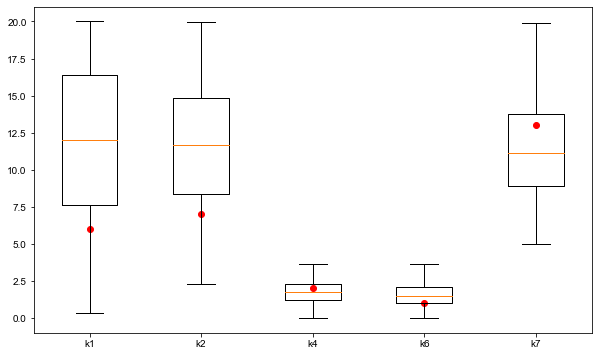

In [168]:
plt.figure(figsize=(10,6))
plt.boxplot(np.vstack(burn_in_chains).T[:5].T,showfliers=False)
plt.scatter(range(1,6),original[:5],color='r')
plt.xticks(range(1,6),names[:5])
# plt.boxplot([chains[0].T[i] for i in range(8)],showfliers=False)
plt.show()

# plt.figure(figsize=(10,6))
# plt.boxplot(chains[0].T[-2:].T,showfliers=False)
# plt.scatter(range(1,3),original[-2:],color='r')
# plt.xticks(range(1,3),names[-2:])
# # plt.boxplot([chains[0].T[i] for i in range(8)],showfliers=False)
# plt.show()

In [182]:
[np.vstack(burn_in_chains).T[5:].T,ratio]

[array([[0.22285949, 0.14362322],
        [0.22517614, 0.15366098],
        [0.22517614, 0.15366098],
        ...,
        [0.2303963 , 0.47145801],
        [0.2303963 , 0.47145801],
        [0.2303963 , 0.47145801]]),
 array([0.31016691, 0.49900102, 0.5081307 , ..., 0.29979802, 0.54905625,
        0.4780507 ])]

In [186]:
small_param_chains = np.vstack([np.vstack(burn_in_chains).T[5].T,np.vstack(burn_in_chains).T[6].T,ratio]).T

In [213]:
np.shape(small_param_chains), np.shape(ratio)

((15000, 3), (5000, 3))

In [191]:
ratio = burn_in_chains.T[0]/(burn_in_chains.T[0]+burn_in_chains.T[1])

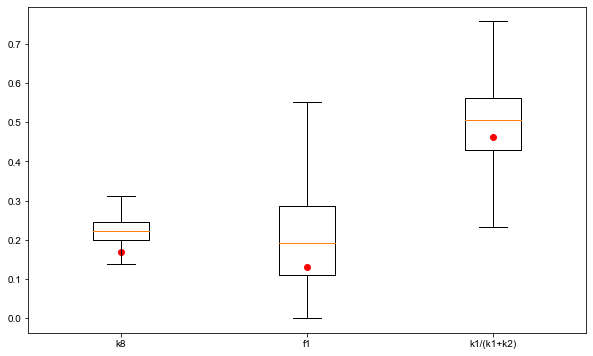

In [192]:
plt.figure(figsize=(10,6))
plt.boxplot(small_param_chains,showfliers=False)
small_param_orig = [original[5], original[6], original[0]/(original[0]+original[1])]
plt.scatter(range(1,4),small_param_orig,color='r')
plt.xticks(range(1,4),['k8','f1','k1/(k1+k2)'])
# plt.boxplot([chains[0].T[i] for i in range(8)],showfliers=False)
plt.show()

# plt.figure(figsize=(10,6))
# plt.boxplot(chains[0].T[-2:].T,showfliers=False)
# plt.scatter(range(1,3),original[-2:],color='r')
# plt.xticks(range(1,3),names[-2:])
# # plt.boxplot([chains[0].T[i] for i in range(8)],showfliers=False)
# plt.show()

/Users/macowner/opt/anaconda3/envs/matlabEnv/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/Users/macowner/opt/anaconda3/envs/matlabEnv/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/Users/macowner/opt/anaconda3/envs/matlabEnv/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword wil

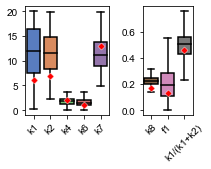

In [313]:

PROPS = {
    'boxprops':{'edgecolor':'black'},
    'medianprops':{'color':'black'},
    'whiskerprops':{'color':'black'},
    'capprops':{'color':'black'}
}

f, (ax_box_1, ax_box_2) = plt.subplots(1,2, sharex=False,gridspec_kw={'width_ratios': [5/8,3/8]},figsize=(3,2))


big_param_chains = np.vstack(burn_in_chains).T[:5]
group_xs = np.hstack([np.ones(15000),2*np.ones(15000),3*np.ones(15000),4*np.ones(15000),5*np.ones(15000)])
sns.boxplot(group_xs,y=np.hstack(big_param_chains), ax=ax_box_1,showfliers=False,palette=sns.color_palette('muted'),**PROPS)

sns.scatterplot(range(0,5),original[:5],color='r',marker='D',s=25,zorder=10, ax = ax_box_1)
ax_box_1.set_xticklabels(names[:5],rotation=45)




small_xs = np.hstack([np.ones(15000),2*np.ones(15000),3*np.ones(15000)])
sns.boxplot(small_xs,y=np.hstack(small_param_chains.T), ax=ax_box_2,showfliers=False,palette=sns.color_palette('muted')[5:],**PROPS)
ax_box_2.set_xticklabels(['k8','f1','k1/(k1+k2)'],rotation=45)
small_param_orig = [original[5], original[6], original[0]/(original[0]+original[1])]
sns.scatterplot(range(0,3),small_param_orig,color='r',marker='D',s=25,zorder=10,ax = ax_box_2)

# # sns.boxplot(x=np.vstack(chains_burnin[1:].T[1]/burn_in_chains[1:].T[0]), ax=ax_box_2,showfliers=False,color='red')

# for j in [0,1,2]:
#     sns.kdeplot(ax=ax_hist,x = (burn_in_chains[j].T[0]/(burn_in_chains[j].T[0]+burn_in_chains[j].T[1])),color=colors[j])

# ax_hist.set_xlim([0,1])
# ax_hist.set_xlabel('k1/(k1+k2)')
# ax_box_1.set(yticks=[])
# ax_box_2.set(yticks=[])

# ax_hist.spines['right'].set_visible(False)
# ax_hist.spines['top'].set_visible(False)
# sns.despine(ax=ax_box_1, left=True)
# sns.despine(ax=ax_box_2, left=True)
# #     plt.tight_layout()

plt.subplots_adjust(wspace=0.5, hspace=1.)
        
# plt.savefig('MCMC_Param_Boxplot_Validation.pdf',dpi=300,bbox_inches = "tight",transparent=True)
